🚀 Using device: cuda
📦 Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
✅ Dataset ready in: maize_dataset
📚 Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]  


📊 Epoch 1/25, Loss: 81.9899, Train Acc: 80.97%, Val Acc: 90.08%
📊 Epoch 2/25, Loss: 51.3392, Train Acc: 89.13%, Val Acc: 89.01%
📊 Epoch 3/25, Loss: 40.4242, Train Acc: 91.04%, Val Acc: 90.92%
📊 Epoch 4/25, Loss: 35.3082, Train Acc: 91.76%, Val Acc: 92.23%
📊 Epoch 5/25, Loss: 38.6569, Train Acc: 91.36%, Val Acc: 91.52%
📊 Epoch 6/25, Loss: 29.7711, Train Acc: 93.47%, Val Acc: 91.88%
📊 Epoch 7/25, Loss: 24.6012, Train Acc: 94.79%, Val Acc: 92.35%
📊 Epoch 8/25, Loss: 24.3137, Train Acc: 94.79%, Val Acc: 91.88%
📊 Epoch 9/25, Loss: 21.8358, Train Acc: 94.90%, Val Acc: 92.00%
📊 Epoch 10/25, Loss: 18.9925, Train Acc: 96.22%, Val Acc: 91.52%
📊 Epoch 11/25, Loss: 18.6903, Train Acc: 95.82%, Val Acc: 91.88%
📊 Epoch 12/25, Loss: 17.1539, Train Acc: 96.34%, Val Acc: 92.59%
📊 Epoch 13/25, Loss: 14.9545, Train Acc: 96.74%, Val Acc: 91.64%
📊 Epoch 14/25, Loss: 13.9887, Train Acc: 96.93%, Val Acc: 93.19%
📊 Epoch 15/25, Loss: 12.2415, Train Acc: 97.33%, Val Acc: 93.07%
📊 Epoch 16/25, Loss: 11.3471, Trai

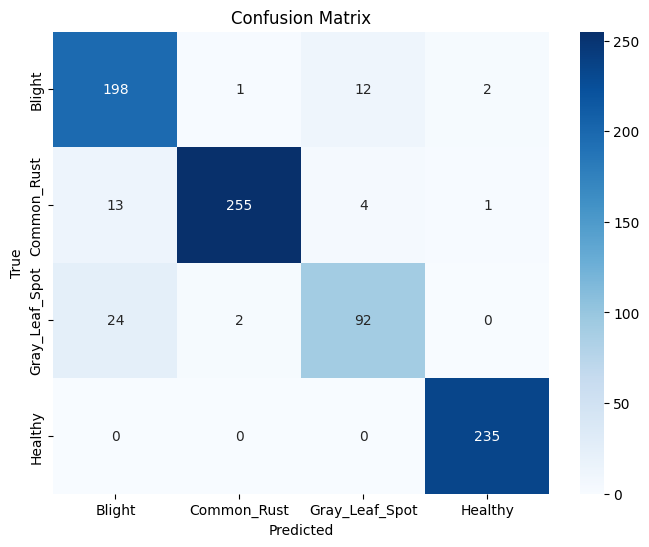

In [1]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Kaggle API setup
os.environ['KAGGLE_USERNAME'] = 'soyebhoque'  
os.environ['KAGGLE_KEY'] = '9f7141c348748368ac975ac380311747'           

# Step 2: Download and prepare the dataset
def download_and_prepare_dataset():
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi()
    api.authenticate()

    dataset_dir = "maize_dataset_raw"
    if not os.path.exists(dataset_dir):
        print("📦 Downloading dataset from Kaggle...")
        api.dataset_download_files('smaranjitghose/corn-or-maize-leaf-disease-dataset',
                                   path=dataset_dir, unzip=True)
    else:
        print("✅ Dataset already downloaded.")

    # Detect extracted folder dynamically
    extracted_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
    if len(extracted_folders) == 1:
        extracted_dir = os.path.join(dataset_dir, extracted_folders[0])
    else:
        raise ValueError("❌ Unable to find extracted dataset folder.")

    # Reorganize to ImageFolder format
    imagefolder_dir = 'maize_dataset'
    if os.path.exists(imagefolder_dir):
        shutil.rmtree(imagefolder_dir)
    os.makedirs(imagefolder_dir, exist_ok=True)

    for folder in os.listdir(extracted_dir):
        src = os.path.join(extracted_dir, folder)
        dst = os.path.join(imagefolder_dir, folder)
        if os.path.isdir(src):
            shutil.move(src, dst)

    print("✅ Dataset ready in:", imagefolder_dir)
    return imagefolder_dir

# Step 3: Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Step 4: Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(15),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Step 5: Load dataset
data_dir = download_and_prepare_dataset()
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print("📚 Classes:", class_names)

# Step 6: Train/val/test split
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Step 7: Weighted loss
targets = [label for _, label in train_set]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Step 8: Load pre-trained VGG16
def get_model(num_classes):
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False  # freeze feature extractor
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model.to(device)

model = get_model(num_classes=len(class_names))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Step 9: Training loop
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=25):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        val_acc = evaluate_model(model, val_loader)
        print(f"📊 Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {100*correct/total:.2f}%, Val Acc: {val_acc:.2f}%")

# Step 10: Evaluate accuracy
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Step 11: Classification report & confusion matrix
def evaluate_with_metrics(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n📈 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Step 12: Run training and testing
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=25)
print("\n🔍 Evaluating on Test Set...")
evaluate_with_metrics(model, test_loader, class_names)

🚀 Using device: cuda
✅ Dataset prepared at maize_dataset with 4188 images
📚 Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚂 Starting training...
Epoch 1/30 - Train Loss: 1.0890, Acc: 82.36% - Val Loss: 0.2261, Acc: 90.44%
Epoch 2/30 - Train Loss: 0.2690, Acc: 92.04% - Val Loss: 0.2494, Acc: 91.64%
Epoch 3/30 - Train Loss: 0.1921, Acc: 94.79% - Val Loss: 0.5300, Acc: 90.08%
Epoch 4/30 - Train Loss: 0.2519, Acc: 93.67% - Val Loss: 0.4507, Acc: 92.11%
Epoch 5/30 - Train Loss: 0.1409, Acc: 96.97% - Val Loss: 0.3900, Acc: 92.00%
Epoch 6/30 - Train Loss: 0.0662, Acc: 98.25% - Val Loss: 0.4457, Acc: 92.71%
Epoch 7/30 - Train Loss: 0.0407, Acc: 98.77% - Val Loss: 0.4077, Acc: 93.19%
Epoch 8/30 - Train Loss: 0.0169, Acc: 99.52% - Val Loss: 0.3632, Acc: 93.31%
Epoch 9/30 - Train Loss: 0.0106, Acc: 99.68% - Val Loss: 0.3713, Acc: 93.19%
Epoch 10/30 - Train Loss: 0.0098, Acc: 99.52% - Val Loss: 0.3741, Acc: 93.07%
Epoch 11/30 - Train Loss: 0.0072, Acc: 99.72% - Val Loss: 0.4447, Acc: 92.95%
Epoch 12/30 - Train Loss: 0.0051, Acc: 99.88% - Val Loss: 0.4412, Acc: 93.67%
Epoch 13/30 - Train Loss: 0.0069, Acc: 99.80% - Va

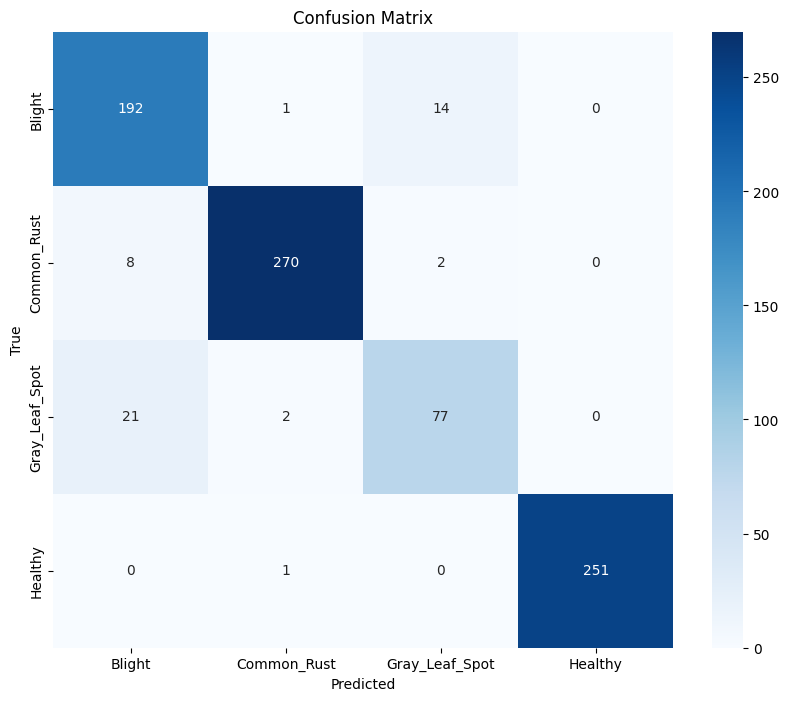

💾 Model saved to maize_disease_model_20250621_180846.pth


In [11]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from kaggle.api.kaggle_api_extended import KaggleApi

# Constants
CONFIG = {
    'image_size': (256, 256),
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 30,
    'patience': 5,  # for early stopping
    'min_lr': 1e-6  # minimum learning rate
}

# Kaggle credentials
KAGGLE_CREDS = {
    'username': 'soyebhoque',
    'key': '9f7141c348748368ac975ac380311747'
}

# === Step 1: Kaggle API setup ===
def setup_kaggle():
    """Initialize and authenticate Kaggle API"""
    # Create .kaggle directory if it doesn't exist
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    
    # Write credentials file
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
        f.write(f'{{"username":"{KAGGLE_CREDS["username"]}","key":"{KAGGLE_CREDS["key"]}"}}')
    
    # Set permissions
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    
    api = KaggleApi()
    api.authenticate()
    return api

# === Step 2: Dataset preparation ===
def prepare_dataset(api):
    """Download and prepare the dataset structure"""
    dataset_dir = "maize_dataset_raw"
    imagefolder_dir = 'maize_dataset'
    
    # Download dataset if needed
    if not os.path.exists(dataset_dir):
        print("📦 Downloading dataset from Kaggle...")
        os.makedirs(dataset_dir, exist_ok=True)
        api.dataset_download_files(
            'smaranjitghose/corn-or-maize-leaf-disease-dataset',
            path=dataset_dir, 
            unzip=True
        )
    
    # Find extracted folder - look for both zip contents and direct folders
    extracted_folders = []
    for f in os.listdir(dataset_dir):
        full_path = os.path.join(dataset_dir, f)
        if os.path.isdir(full_path):
            # Skip the __MACOSX folder if it exists
            if f != '__MACOSX':
                extracted_folders.append(f)
    
    # Also check for files that might have been extracted directly
    if not extracted_folders:
        # Check if images are directly in the dataset_dir
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(dataset_dir)):
            extracted_dir = dataset_dir
        else:
            raise RuntimeError("No valid dataset folders or images found in the dataset directory")
    else:
        extracted_dir = os.path.join(dataset_dir, extracted_folders[0])
    
    # Prepare clean folder structure
    if os.path.exists(imagefolder_dir):
        shutil.rmtree(imagefolder_dir)
    os.makedirs(imagefolder_dir, exist_ok=True)

    # If files were extracted directly, we need to organize them by class
    if extracted_dir == dataset_dir:
        # This dataset should already have class folders, but if not:
        class_folders = [f for f in os.listdir(extracted_dir) 
                        if os.path.isdir(os.path.join(extracted_dir, f))]
        if not class_folders:
            raise RuntimeError("Dataset is not organized in class folders")
            
        # Move each class folder to our organized directory
        for class_folder in class_folders:
            src = os.path.join(extracted_dir, class_folder)
            dst = os.path.join(imagefolder_dir, class_folder)
            shutil.move(src, dst)
    else:
        # Original logic for moving files
        for class_folder in os.listdir(extracted_dir):
            src = os.path.join(extracted_dir, class_folder)
            if os.path.isdir(src):
                dst = os.path.join(imagefolder_dir, class_folder)
                shutil.move(src, dst)
    
    # Verify we have images
    total_images = 0
    for class_folder in os.listdir(imagefolder_dir):
        class_path = os.path.join(imagefolder_dir, class_folder)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            total_images += count
            if count == 0:
                raise RuntimeError(f"No images found in class folder: {class_folder}")
    
    if total_images == 0:
        raise RuntimeError("No images found in the dataset")
    
    print(f"✅ Dataset prepared at {imagefolder_dir} with {total_images} images")
    return imagefolder_dir

# === Step 3: Image transformations ===
def get_transforms():
    """Return train and validation transforms"""
    return {
        'train': transforms.Compose([
            transforms.Resize(CONFIG['image_size']),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.GaussianBlur(3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(CONFIG['image_size']),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

# === Step 4: Model architecture ===
def get_model(num_classes):
    """Initialize and configure VGG16 model"""
    model = models.vgg16(pretrained=True)
    
    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Modify classifier
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
    
    return model

# === Step 5: Training loop ===
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    """Train the model with early stopping and checkpointing"""
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=CONFIG['patience']//2, 
                                factor=0.5, min_lr=CONFIG['min_lr'])
    best_acc = 0.0
    best_model_wts = None
    early_stop_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        
        # Early stopping and model checkpointing
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= CONFIG['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# === Step 6: Model evaluation ===
def evaluate_model(model, criterion, loader):
    """Evaluate model performance"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader.dataset)
    accuracy = 100 * correct / total
    return loss, accuracy

def evaluate_with_metrics(model, loader, class_names):
    """Generate classification report and confusion matrix"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n📈 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# === Main Execution ===
if __name__ == "__main__":
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Using device: {device}")
    
    try:
        # Prepare data
        api = setup_kaggle()
        data_dir = prepare_dataset(api)
        transforms = get_transforms()
        
        # Load datasets
        full_dataset = datasets.ImageFolder(root=data_dir, transform=transforms['train'])
        class_names = full_dataset.classes
        print("📚 Classes:", class_names)
        
        # Split dataset
        train_size = int(0.6 * len(full_dataset))
        val_size = int(0.2 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
        
        # Apply validation transforms to val and test sets
        val_set.dataset.transform = transforms['val']
        test_set.dataset.transform = transforms['val']
        
        # Create data loaders
        train_loader = DataLoader(train_set, batch_size=CONFIG['batch_size'], 
                                shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=CONFIG['batch_size'], 
                              shuffle=False, num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], 
                               shuffle=False, num_workers=4, pin_memory=True)
        
        # Compute class weights
        targets = [label for _, label in train_set]
        class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
        weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights_tensor)
        
        # Initialize model
        model = get_model(len(class_names)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
        
        # Train model
        print("🚂 Starting training...")
        trained_model = train_model(
            model, criterion, optimizer, 
            train_loader, val_loader, 
            epochs=CONFIG['epochs']
        )
        
        # Final evaluation
        print("\n🔍 Final Evaluation on Test Set:")
        evaluate_with_metrics(trained_model, test_loader, class_names)
        
        # Save model
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_path = f"maize_disease_model_{timestamp}.pth"
        torch.save(trained_model.state_dict(), model_path)
        print(f"💾 Model saved to {model_path}")
        
    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")